In [1]:
pip install -q scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [4]:
import os
base_dir = 'output'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32
shape = (224, 224)

## Testing different pre-trained models

In [9]:
# importing layers and models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Activation
from tensorflow.keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import DenseNet121, DenseNet201, ResNet50, ResNet152

shape = (224, 224)
train_gen = datagen.flow_from_directory(train_dir, target_size = shape, batch_size = batch_size, class_mode = 'categorical', color_mode = 'rgb', shuffle=False)
valid_gen = test_datagen.flow_from_directory(validation_dir, target_size = shape, batch_size = batch_size, class_mode = 'categorical', color_mode = 'rgb', shuffle=False)
test_gen = test_datagen.flow_from_directory(test_dir, target_size = shape, batch_size = batch_size, class_mode = 'categorical', color_mode = 'rgb', shuffle=False)

# VGG16
base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False    
predictions = Flatten()(base_model.output)
model_VGG16 = Model(inputs=base_model.input, outputs=predictions)

# VGG19
model_VGG19 = VGG19(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# InceptionV3
model_InceptionV3 = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# InceptionV4
model_InceptionV4 = InceptionResNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# DenseNet121
model_DenseNet121 = DenseNet121(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# DenseNet201
model_DenseNet201 = DenseNet201(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

model_list = [model_VGG16]
dropout_list = [0.6]
acc_list = []

for dropout in dropout_list:
    base_model = model_VGG16
    for layer in base_model.layers:
        layer.trainable = False    
    predictions = Flatten()(base_model.output)
    model = Model(inputs=base_model.input, outputs=predictions)

    from keras.callbacks import EarlyStopping
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 200)
    from keras.callbacks import ModelCheckpoint
    mc1 = ModelCheckpoint('best_modelACC.h5', monitor = 'val_categorical_accuracy', mode = 'max', verbose = 0, save_best_only = True)
    mc2 = ModelCheckpoint('best_modelLOSS.h5', monitor = 'val_loss', mode = 'min', verbose = 0, save_best_only = True)

    from tensorflow.keras.optimizers import Adam
    adam = Adam(learning_rate=0.00001)

    
    # getting X_train, y_train, X_test, y_test, X_valid, y_valid from the generators
    train_gen.reset()
    X_train, y_train = next(train_gen)
    X_train = model.predict(X_train)
    for i in range(len(train_gen)-1): #1st batch is already fetched before the for loop.
        img, label = next(train_gen)
        X_train = np.append(X_train, model.predict(np.array(img)), axis = 0)
        y_train = np.append(y_train, label, axis=0)
    print(X_train.shape, y_train.shape)
    train_gen.reset()

    test_gen.reset()
    X_test, y_test = next(test_gen)
    X_test = model.predict(X_test)
    for i in range(len(test_gen)-1): #1st batch is already fetched before the for loop.
        img, label = next(test_gen)
        X_test = np.append(X_test, model.predict(np.array(img)), axis = 0)
        y_test = np.append(y_test, label, axis=0)
    print(X_test.shape, y_test.shape)
    test_gen.reset()

    valid_gen.reset()
    X_valid, y_valid = next(valid_gen)
    X_valid = model.predict(X_valid)
    for i in range(len(valid_gen)-1): #1st batch is already fetched before the for loop.
        img, label = next(valid_gen)
        X_valid = np.append(X_valid, model.predict(np.array(img)), axis = 0)
        y_valid = np.append(y_valid, label, axis=0)
    print(X_valid.shape, y_valid.shape)
    valid_gen.reset()

    from sklearn import utils
    utils.shuffle(X_train, y_train)
    
    # initializer = tf.keras.initializers.HeNormal()
    model = tf.keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1000, activation=tf.keras.activations.relu))
    model.add(Dropout(dropout))
    model.add(Dense(1000, activation=tf.keras.activations.relu))
    model.add(Dropout(dropout))
    model.add(Dense(1000, activation=tf.keras.activations.relu))
    model.add(Dropout(dropout))
    model.add(Dense(1000, activation=tf.keras.activations.relu))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax"))

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    epochs = 2000

    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = 32,
        epochs=epochs,
        verbose = 1,
        validation_data=(X_valid, y_valid),
        callbacks = [es,mc1,mc2]
        )
    
    l = []
    
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))
    
    modelACC = tf.keras.models.load_model("best_modelACC.h5")
    _, acc = modelACC.evaluate(X_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))
    l.append(acc)

    modelLOSS = tf.keras.models.load_model("best_modelLOSS.h5")
    _, acc = modelLOSS.evaluate(X_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))
    l.append(acc)
    acc_list.append(l)

Found 5062 images belonging to 3 classes.
Found 631 images belonging to 3 classes.
Found 637 images belonging to 3 classes.
1/1 [==============================] - 0s 498ms/step
(5062, 25088) (5062, 3)
1/1 [==============================] - 1s 690ms/step
(637, 25088) (637, 3)
1/1 [==============================] - 1s 564ms/step
(631, 25088) (631, 3)
Epoch 1/2000
159/159 [==============================] - 3s 10ms/step - loss: 2.6325 - categorical_accuracy: 0.3832 - val_loss: 1.0011 - val_categorical_accuracy: 0.4913
Epoch 2/2000
159/159 [==============================] - 1s 9ms/step - loss: 2.4076 - categorical_accuracy: 0.3957 - val_loss: 0.9653 - val_categorical_accuracy: 0.5388
Epoch 3/2000
159/159 [==============================] - 1s 9ms/step - loss: 2.2680 - categorical_accuracy: 0.4075 - val_loss: 0.9290 - val_categorical_accuracy: 0.5452
Epoch 4/2000
159/159 [==============================] - 1s 9ms/step - loss: 2.1169 - categorical_accuracy: 0.4085 - val_loss: 0.9053 - val_categ

159/159 [==============================] - 1s 7ms/step - loss: 0.8446 - categorical_accuracy: 0.6075 - val_loss: 0.6443 - val_categorical_accuracy: 0.7036
Epoch 36/2000
159/159 [==============================] - 1s 9ms/step - loss: 0.8133 - categorical_accuracy: 0.6179 - val_loss: 0.6348 - val_categorical_accuracy: 0.7163
Epoch 37/2000
159/159 [==============================] - 1s 9ms/step - loss: 0.8002 - categorical_accuracy: 0.6183 - val_loss: 0.6290 - val_categorical_accuracy: 0.7179
Epoch 38/2000
159/159 [==============================] - 1s 9ms/step - loss: 0.7992 - categorical_accuracy: 0.6193 - val_loss: 0.6250 - val_categorical_accuracy: 0.7258
Epoch 39/2000
159/159 [==============================] - 1s 9ms/step - loss: 0.7777 - categorical_accuracy: 0.6357 - val_loss: 0.6189 - val_categorical_accuracy: 0.7306
Epoch 40/2000
159/159 [==============================] - 2s 10ms/step - loss: 0.7436 - categorical_accuracy: 0.6468 - val_loss: 0.6115 - val_categorical_accuracy: 0.7401

159/159 [==============================] - 1s 7ms/step - loss: 0.1170 - categorical_accuracy: 0.9554 - val_loss: 0.1071 - val_categorical_accuracy: 0.9731
Epoch 132/2000
159/159 [==============================] - 1s 9ms/step - loss: 0.1117 - categorical_accuracy: 0.9581 - val_loss: 0.0982 - val_categorical_accuracy: 0.9778
Epoch 133/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.1204 - categorical_accuracy: 0.9520 - val_loss: 0.1005 - val_categorical_accuracy: 0.9746
Epoch 134/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.1161 - categorical_accuracy: 0.9561 - val_loss: 0.1001 - val_categorical_accuracy: 0.9731
Epoch 135/2000
159/159 [==============================] - 1s 7ms/step - loss: 0.1204 - categorical_accuracy: 0.9554 - val_loss: 0.0975 - val_categorical_accuracy: 0.9731
Epoch 136/2000
159/159 [==============================] - 1s 7ms/step - loss: 0.1078 - categorical_accuracy: 0.9621 - val_loss: 0.0960 - val_categorical_accuracy: 0.

159/159 [==============================] - 1s 5ms/step - loss: 0.0320 - categorical_accuracy: 0.9893 - val_loss: 0.0469 - val_categorical_accuracy: 0.9842
Epoch 228/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0330 - categorical_accuracy: 0.9899 - val_loss: 0.0446 - val_categorical_accuracy: 0.9842
Epoch 229/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0332 - categorical_accuracy: 0.9895 - val_loss: 0.0434 - val_categorical_accuracy: 0.9842
Epoch 230/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0309 - categorical_accuracy: 0.9901 - val_loss: 0.0444 - val_categorical_accuracy: 0.9857
Epoch 231/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0309 - categorical_accuracy: 0.9907 - val_loss: 0.0443 - val_categorical_accuracy: 0.9857
Epoch 232/2000
159/159 [==============================] - 1s 7ms/step - loss: 0.0261 - categorical_accuracy: 0.9899 - val_loss: 0.0432 - val_categorical_accuracy: 0.

159/159 [==============================] - 1s 7ms/step - loss: 0.0123 - categorical_accuracy: 0.9960 - val_loss: 0.0297 - val_categorical_accuracy: 0.9905
Epoch 324/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0164 - categorical_accuracy: 0.9935 - val_loss: 0.0304 - val_categorical_accuracy: 0.9889
Epoch 325/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0120 - categorical_accuracy: 0.9960 - val_loss: 0.0305 - val_categorical_accuracy: 0.9889
Epoch 326/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0131 - categorical_accuracy: 0.9960 - val_loss: 0.0297 - val_categorical_accuracy: 0.9905
Epoch 327/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0137 - categorical_accuracy: 0.9957 - val_loss: 0.0300 - val_categorical_accuracy: 0.9889
Epoch 328/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0137 - categorical_accuracy: 0.9960 - val_loss: 0.0324 - val_categorical_accuracy: 0.

159/159 [==============================] - 1s 5ms/step - loss: 0.0081 - categorical_accuracy: 0.9970 - val_loss: 0.0333 - val_categorical_accuracy: 0.9873
Epoch 420/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0065 - categorical_accuracy: 0.9982 - val_loss: 0.0304 - val_categorical_accuracy: 0.9905
Epoch 421/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.0067 - categorical_accuracy: 0.9976 - val_loss: 0.0306 - val_categorical_accuracy: 0.9905
Epoch 422/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0089 - categorical_accuracy: 0.9970 - val_loss: 0.0376 - val_categorical_accuracy: 0.9873
Epoch 423/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0074 - categorical_accuracy: 0.9980 - val_loss: 0.0409 - val_categorical_accuracy: 0.9873
Epoch 424/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.0037 - categorical_accuracy: 0.9986 - val_loss: 0.0378 - val_categorical_accuracy: 0.

159/159 [==============================] - 1s 5ms/step - loss: 0.0058 - categorical_accuracy: 0.9980 - val_loss: 0.0340 - val_categorical_accuracy: 0.9905
Epoch 516/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0035 - categorical_accuracy: 0.9978 - val_loss: 0.0340 - val_categorical_accuracy: 0.9905
Epoch 517/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0048 - categorical_accuracy: 0.9982 - val_loss: 0.0403 - val_categorical_accuracy: 0.9905
Epoch 518/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0034 - categorical_accuracy: 0.9984 - val_loss: 0.0413 - val_categorical_accuracy: 0.9905
Epoch 519/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0048 - categorical_accuracy: 0.9988 - val_loss: 0.0445 - val_categorical_accuracy: 0.9905
Epoch 520/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0063 - categorical_accuracy: 0.9978 - val_loss: 0.0419 - val_categorical_accuracy: 0.

159/159 [==============================] - 1s 5ms/step - loss: 0.0030 - categorical_accuracy: 0.9988 - val_loss: 0.0323 - val_categorical_accuracy: 0.9937
Epoch 612/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0045 - categorical_accuracy: 0.9982 - val_loss: 0.0297 - val_categorical_accuracy: 0.9937
Epoch 613/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.0056 - categorical_accuracy: 0.9990 - val_loss: 0.0345 - val_categorical_accuracy: 0.9889
Epoch 614/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0065 - categorical_accuracy: 0.9982 - val_loss: 0.0367 - val_categorical_accuracy: 0.9905
Epoch 615/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0030 - categorical_accuracy: 0.9996 - val_loss: 0.0308 - val_categorical_accuracy: 0.9921
Epoch 616/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.0084 - categorical_accuracy: 0.9984 - val_loss: 0.0313 - val_categorical_accuracy: 0.

159/159 [==============================] - 1s 5ms/step - loss: 0.0023 - categorical_accuracy: 0.9992 - val_loss: 0.0351 - val_categorical_accuracy: 0.9921
Epoch 708/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0035 - categorical_accuracy: 0.9994 - val_loss: 0.0399 - val_categorical_accuracy: 0.9921
Epoch 709/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0029 - categorical_accuracy: 0.9986 - val_loss: 0.0442 - val_categorical_accuracy: 0.9921
Epoch 710/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0050 - categorical_accuracy: 0.9990 - val_loss: 0.0447 - val_categorical_accuracy: 0.9921
Epoch 711/2000
159/159 [==============================] - 1s 4ms/step - loss: 0.0035 - categorical_accuracy: 0.9992 - val_loss: 0.0441 - val_categorical_accuracy: 0.9921
Epoch 712/2000
159/159 [==============================] - 1s 5ms/step - loss: 0.0038 - categorical_accuracy: 0.9990 - val_loss: 0.0420 - val_categorical_accuracy: 0.

## Testing the best models

In [10]:
print(acc_list)

[[0.9968602657318115, 0.9937205910682678]]


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def predict(model, X, y):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis = 1)
    y_true = np.argmax(y, axis = 1) 
    return y_true, y_pred

def confusionMatrix(y_true, y_pred, title):
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot = True, fmt = 'g')
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(title)

20/20 [==============================] - 0s 2ms/step


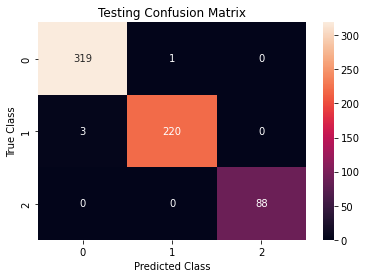

In [29]:
arr = [2, 0, 1]
y_true, y_pred = predict(modelACC, X_valid, y_valid)
for i, j in enumerate(y_true):
    y_true[i] = arr[j]
for i, j in enumerate(y_pred):
    y_pred[i] = arr[j]
confusionMatrix(y_true, y_pred, "Testing Confusion Matrix")

20/20 [==============================] - 0s 11ms/step


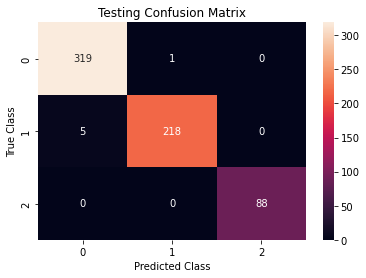

In [28]:
y_true, y_pred = predict(modelLOSS, X_valid, y_valid)
for i, j in enumerate(y_true):
    y_true[i] = arr[j]
for i, j in enumerate(y_pred):
    y_pred[i] = arr[j]
confusionMatrix(y_true, y_pred, "Testing Confusion Matrix")

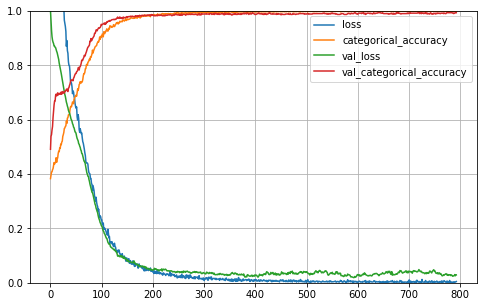

In [30]:
# Plot the history
df = pd.DataFrame(history.history)
df.plot(figsize = (8,5))
plt.grid(True)
plt.ylim(0,1)
plt.savefig('VGG16.png')
plt.show()

In [ ]:
# model = tf.keras.Sequential()
# model.add(model_VGG16)
# model.add(Flatten())
# model.add(modelLOSS)
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# model.save("best_model.h5")